# Cross-Validation and Metrics

In previous tutorials, we have seen how to build forecasters, work with exogenous variables, and create pipelines. Now, we will learn how to properly evaluate our forecasting models using cross-validation techniques and performance metrics.

**Duration:** ~15 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Understand the importance of temporal cross-validation for time series
- Use different splitters to create train/test windows
- Visualize splitting strategies with `plot_windows`
- Understand the difference between non-scaled and scaled metrics
- Use the `evaluate` function to benchmark forecasters

## Why is Cross-Validation Different for Time Series?

In traditional machine learning, we can randomly shuffle data before splitting into train and test sets. However, for time series, **we cannot randomly shuffle** because:

1. **Temporal order matters**: Past values are used to predict future values
2. **Information leakage**: Using future data to train would give unrealistic performance estimates
3. **Non-stationarity**: The statistical properties of time series can change over time

Therefore, we need specialized splitters that respect the temporal ordering of the data.

## 1. Loading Example Data

Let's load a dataset to work with throughout this tutorial.

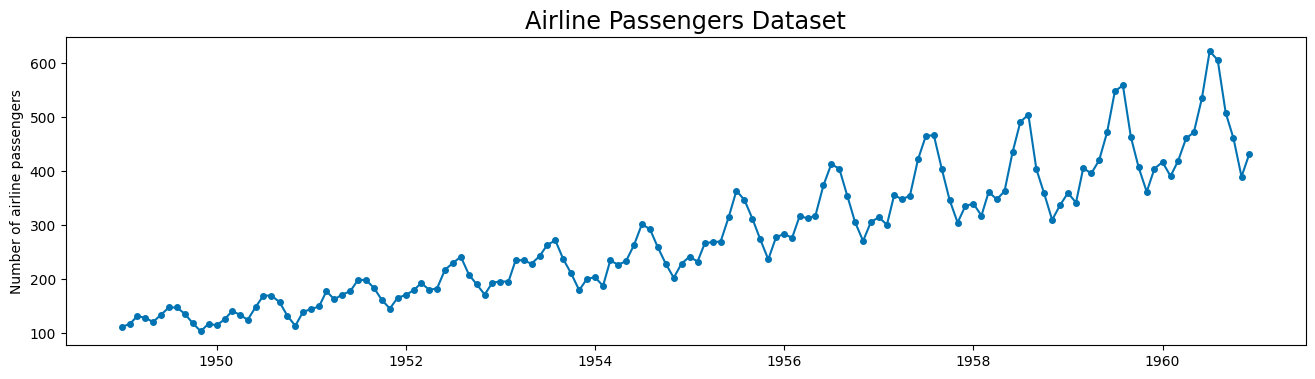

Dataset length: 144 time points


In [1]:
import matplotlib.pyplot as plt

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

# Load airline passengers dataset
y = load_airline()

plot_series(y, title="Airline Passengers Dataset")
plt.show()

print(f"Dataset length: {len(y)} time points")

## 2. Splitters in sktime

`sktime` provides several temporal splitters in the `sktime.split` module. These splitters ensure we always train on past data and test on future data. 

The most commonly used splitters are:

| Splitter | Description |
|----------|-------------|
| `temporal_train_test_split` | Simple single train/test split |
| `SlidingWindowSplitter` | Fixed-size training window that slides forward |
| `ExpandingWindowSplitter` | Growing training window that expands forward |
| `SingleWindowSplitter` | Single window split with customizable forecast horizon |

Let's explore each of these splitters.

### 2.1 Simple Train/Test Split with `temporal_train_test_split`

The simplest form of temporal splitting is a single train/test split. This is useful for quick evaluations.

Train set: 115 samples (1949-01 to 1958-07)
Test set: 29 samples (1958-08 to 1960-12)


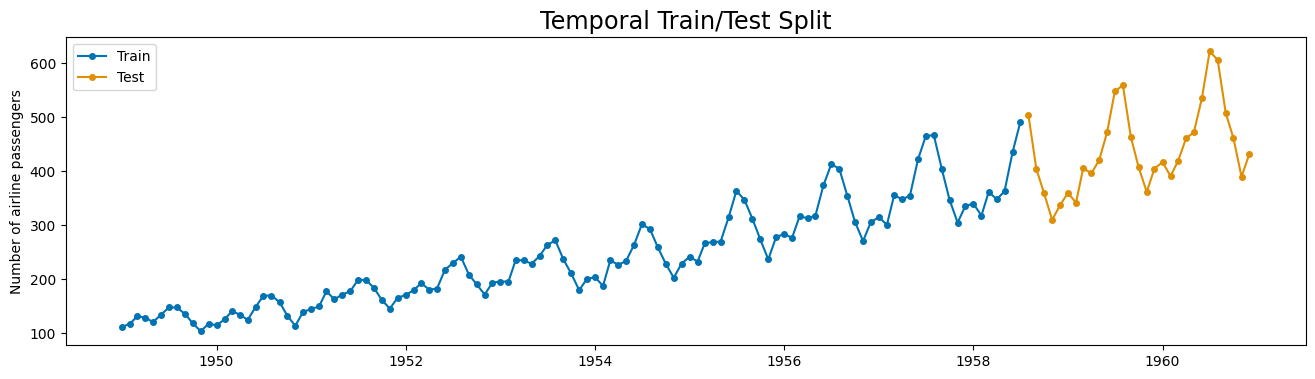

In [2]:
from sktime.split import temporal_train_test_split

# Split the data: 80% train, 20% test
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

print(f"Train set: {len(y_train)} samples ({y_train.index[0]} to {y_train.index[-1]})")
print(f"Test set: {len(y_test)} samples ({y_test.index[0]} to {y_test.index[-1]})")

plot_series(y_train, y_test, labels=["Train", "Test"], title="Temporal Train/Test Split")
plt.show()

### 2.2 Sliding Window Splitter

The `SlidingWindowSplitter` creates multiple folds with a **fixed-size training window** that slides forward through time. Key parameters:

- `window_length`: Size of the training window
- `fh`: Forecast horizon (which future points to predict)
- `step_length`: How much to move the window forward each fold

In [3]:
from sktime.split import SlidingWindowSplitter

# Create a sliding window splitter
# window_length=36: use 36 months (3 years) for training
# fh=[1, 2, 3, ..., 12]: forecast 12 months ahead
# step_length=12: move the window 12 months forward each fold
cv_sliding = SlidingWindowSplitter(
    window_length=36, 
    fh=list(range(1, 13)),  # 12-step ahead forecast
    step_length=12
)

print(f"Number of folds: {cv_sliding.get_n_splits(y)}")

Number of folds: 9


### 2.3 Visualizing Splits with `plot_windows`

`sktime` provides a convenient `plot_windows` function to visualize how splitters divide the data. This is extremely useful for understanding what your cross-validation strategy is doing.

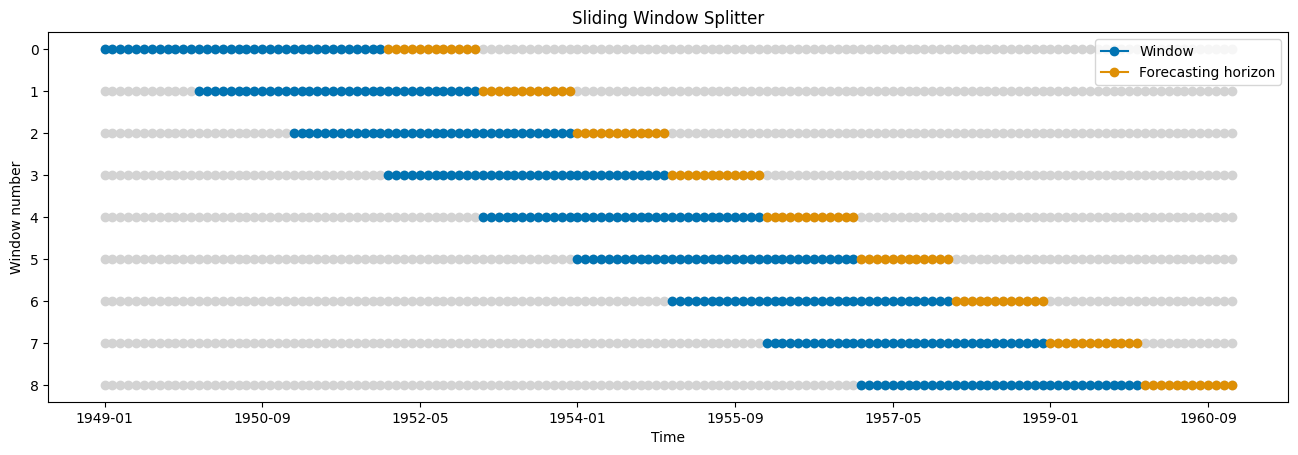

In [4]:
from sktime.utils.plotting import plot_windows

# Visualize the sliding window splits
plot_windows(cv_sliding, y, title="Sliding Window Splitter")
plt.show()

In the plot above:
- **Orange dots** represent the training window
- **Blue dots** represent the test window (forecast horizon)
- Each row is a different fold
- Gray dots show unused data points for that fold

Notice how the training window **stays the same size** but slides forward through time.

### 2.4 Expanding Window Splitter

The `ExpandingWindowSplitter` creates folds with a **growing training window**. Unlike sliding window, it uses all available historical data up to each cutoff point.

In [5]:
from sktime.split import ExpandingWindowSplitter

# Create an expanding window splitter
# initial_window=36: start with 36 months (3 years) for training
# fh=[1, 2, 3, ..., 12]: forecast 12 months ahead
# step_length=12: expand the window 12 months forward each fold
cv_expanding = ExpandingWindowSplitter(
    initial_window=36, 
    fh=list(range(1, 13)), 
    step_length=12
)

print(f"Number of folds: {cv_expanding.get_n_splits(y)}")

Number of folds: 9


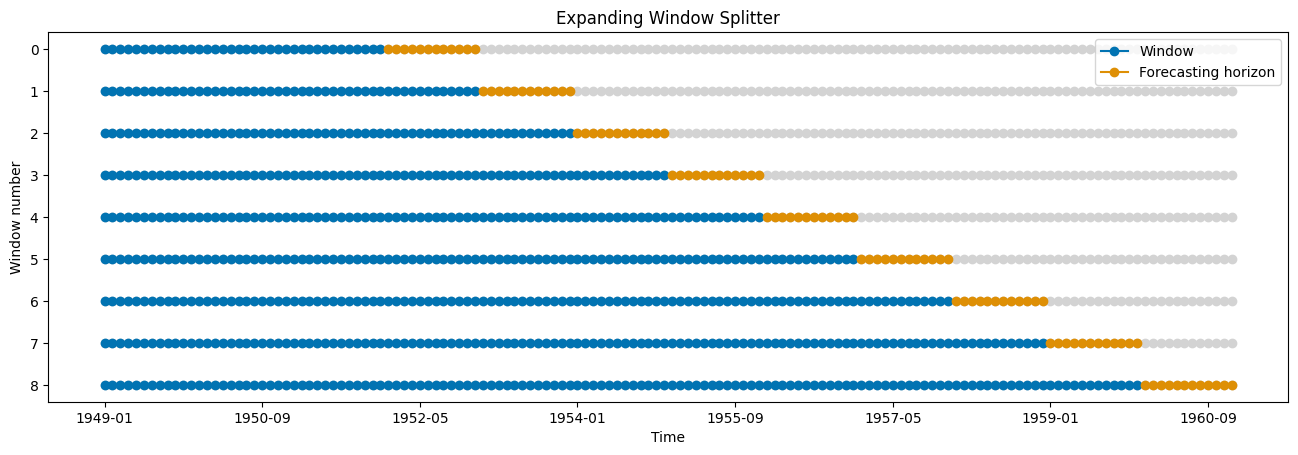

In [6]:
# Visualize the expanding window splits
plot_windows(cv_expanding, y, title="Expanding Window Splitter")
plt.show()

Notice how the training window **grows** with each fold, incorporating more historical data. This is often preferred when you believe more data leads to better models.

### 2.5 When to Use Which Splitter?

| Splitter | Use When |
|----------|----------|
| `SlidingWindowSplitter` | You believe only recent data is relevant (concept drift, changing patterns) |
| `ExpandingWindowSplitter` | You want to use all available historical data |
| `SingleWindowSplitter` | You need just one train/test split with a specific forecast horizon |

## 3. Forecasting Performance Metrics

Once we have our train/test splits, we need metrics to evaluate how good our forecasts are. `sktime` provides a rich set of metrics in `sktime.performance_metrics.forecasting`.

Metrics can be broadly categorized into two groups:
1. **Non-scaled metrics**: Depend on the scale of the data
2. **Scaled metrics**: Normalized, allowing comparison across different datasets

### 3.1 Non-Scaled Metrics

These metrics are in the same units as your data. Common examples:

| Metric | Description |
|--------|-------------|
| `MeanAbsoluteError` (MAE) | Average absolute difference between predicted and actual |
| `MeanSquaredError` (MSE) | Average squared difference (penalizes large errors more) |
| `MedianAbsoluteError` | Median of absolute differences (robust to outliers) |

Let's see them in action:

In [7]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError,
    MedianAbsoluteError,
)

# Create and fit a simple forecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# Make predictions
y_pred = forecaster.predict(fh=list(range(1, len(y_test) + 1)))

# Compute non-scaled metrics
mae = MeanAbsoluteError()
mse = MeanSquaredError()
medae = MedianAbsoluteError()

print(f"Mean Absolute Error: {mae(y_test, y_pred):.2f}")
print(f"Mean Squared Error: {mse(y_test, y_pred):.2f}")
print(f"Median Absolute Error: {medae(y_test, y_pred):.2f}")

Mean Absolute Error: 81.45
Mean Squared Error: 8673.93
Median Absolute Error: 84.00


These values are in the units of our data (number of passengers). This makes them easy to interpret, but hard to compare across different datasets or time series with different scales.

### 3.2 Scaled Metrics

Scaled metrics are normalized, making them interpretable as percentages or relative to a baseline. Common examples:

| Metric | Description |
|--------|-------------|
| `MeanAbsolutePercentageError` (MAPE) | Error as a percentage of actual values |
| `MeanAbsoluteScaledError` (MASE) | Error scaled by the in-sample naive forecast error |
| `MeanRelativeAbsoluteError` (MRAE) | Error relative to a benchmark forecaster |

**MASE** is particularly useful because:
- It's scale-independent (works across different datasets)
- A value < 1 means the model beats the naive baseline
- A value > 1 means the naive baseline is better

In [8]:
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

# Compute scaled metrics
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

print(f"Mean Absolute Percentage Error: {mape(y_test, y_pred) * 100:.2f}%")

# MASE requires the training data to compute the scaling factor
print(f"Mean Absolute Scaled Error: {mase(y_test, y_pred, y_train=y_train):.2f}")

Mean Absolute Percentage Error: 20.20%
Mean Absolute Scaled Error: 3.87


A MASE value close to 1 for our Naive forecaster makes sense - it's being compared against itself (the naive baseline)!

Let's compare with a more sophisticated model:

In [9]:
from sktime.forecasting.trend import TrendForecaster

# Try a trend-based forecaster
trend_forecaster = TrendForecaster()
trend_forecaster.fit(y_train)
y_pred_trend = trend_forecaster.predict(fh=list(range(1, len(y_test) + 1)))

print("Trend Forecaster Performance:")
print(f"  MAPE: {mape(y_test, y_pred_trend) * 100:.2f}%")
print(f"  MASE: {mase(y_test, y_pred_trend, y_train=y_train):.2f}")
print()
print("Naive Forecaster Performance:")
print(f"  MAPE: {mape(y_test, y_pred) * 100:.2f}%")
print(f"  MASE: {mase(y_test, y_pred, y_train=y_train):.2f}")

Trend Forecaster Performance:
  MAPE: 12.07%
  MASE: 2.66

Naive Forecaster Performance:
  MAPE: 20.20%
  MASE: 3.87


## 4. The `evaluate` Function

While we can manually loop through splits and compute metrics, `sktime` provides the powerful `evaluate` function that does all of this for us. It's the recommended way to benchmark forecasters.

The `evaluate` function:
1. Splits data according to the provided splitter
2. Fits/updates the forecaster on each training fold
3. Makes predictions on each test fold  
4. Computes metrics and timing information
5. Returns a comprehensive DataFrame with results

In [10]:
from sktime.forecasting.model_evaluation import evaluate

# Create a cross-validator
cv = ExpandingWindowSplitter(
    initial_window=36, 
    fh=list(range(1, 13)), 
    step_length=12
)

# Evaluate the forecaster
results = evaluate(
    forecaster=NaiveForecaster(strategy="last"),
    cv=cv,
    y=y,
    scoring=MeanAbsolutePercentageError(),
    return_data=True  # Include train/test/pred data in results
)

results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.147448,0.002580,0.007689,36,1951-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1952-01 171.0 1952-02 180.0 1952-03 1...,1952-01 166.0 1952-02 166.0 1952-03 1...
1,0.137821,0.002368,0.007601,48,1952-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1953-01 196.0 1953-02 196.0 1953-03 2...,1953-01 194.0 1953-02 194.0 1953-03 1...
2,0.154125,0.002348,0.006830,60,1953-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1954-01 204.0 1954-02 188.0 1954-03 2...,1954-01 201.0 1954-02 201.0 1954-03 2...
3,0.178165,0.002434,0.006719,72,1954-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1955-01 242.0 1955-02 233.0 1955-03 2...,1955-01 229.0 1955-02 229.0 1955-03 2...
4,0.142354,0.002385,0.005943,84,1955-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1956-01 284.0 1956-02 277.0 1956-03 3...,1956-01 278.0 1956-02 278.0 1956-03 2...
5,0.154935,0.002341,0.005777,96,1956-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1957-01 315.0 1957-02 301.0 1957-03 3...,1957-01 306.0 1957-02 306.0 1957-03 3...
6,0.120517,0.002336,0.006073,108,1957-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1958-01 340.0 1958-02 318.0 1958-03 3...,1958-01 336.0 1958-02 336.0 1958-03 3...
7,0.195363,0.002266,0.005778,120,1958-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1959-01 360.0 1959-02 342.0 1959-03 4...,1959-01 337.0 1959-02 337.0 1959-03 3...
8,0.142513,0.002471,0.006239,132,1959-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1960-01 417.0 1960-02 391.0 1960-03 4...,1960-01 405.0 1960-02 405.0 1960-03 4...


The results DataFrame contains:
- `test_MeanAbsolutePercentageError`: The metric score for each fold
- `fit_time`: Time to fit the model
- `pred_time`: Time to make predictions
- `len_train_window`: Size of training set for each fold
- `cutoff`: The last timestamp of the training window
- `y_train`, `y_test`, `y_pred`: The actual data (when `return_data=True`)

In [11]:
# Get summary statistics of the cross-validation performance
print(f"Average MAPE across folds: {results['test_MeanAbsolutePercentageError'].mean() * 100:.2f}%")
print(f"Std MAPE across folds: {results['test_MeanAbsolutePercentageError'].std() * 100:.2f}%")

Average MAPE across folds: 15.26%
Std MAPE across folds: 2.23%


### 4.1 Using Multiple Metrics

You can pass a list of metrics to `evaluate` to compute multiple metrics at once:

In [12]:
# Evaluate with multiple metrics
results_multi = evaluate(
    forecaster=NaiveForecaster(strategy="last"),
    cv=cv,
    y=y,
    scoring=[
        MeanAbsoluteError(),
        MeanSquaredError(square_root=True),  # RMSE
        MeanAbsolutePercentageError(),
    ],
)

results_multi

,test_MeanAbsoluteError,test_MeanSquaredError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,31.000000,38.006578,0.147448,0.002395,0.007322,36,1951-12
1,33.333333,41.277516,0.137821,0.002413,0.006549,48,1952-12
2,40.083333,50.554426,0.154125,0.002604,0.007016,60,1953-12
3,55.000000,68.211680,0.178165,0.002479,0.006765,72,1954-12
4,51.583333,68.006740,0.142354,0.002458,0.006617,84,1955-12
5,63.416667,83.474048,0.154935,0.002349,0.006512,96,1956-12
6,52.333333,76.434067,0.120517,0.002404,0.006237,108,1957-12
7,91.333333,113.188633,0.195363,0.002278,0.006107,120,1958-12
8,76.000000,102.976535,0.142513,0.002335,0.006138,132,1959-12


### 4.2 Evaluation Strategies

The `evaluate` function supports different strategies for updating the forecaster between folds:

| Strategy | Description |
|----------|-------------|
| `"refit"` | Refit the model from scratch on each training window (default) |
| `"update"` | Update the model with new data (faster, if model supports it) |
| `"no-update_params"` | Only update the cutoff, don't retrain |

In [13]:
# Compare refit vs update strategies
results_refit = evaluate(
    forecaster=NaiveForecaster(strategy="last"),
    cv=cv,
    y=y,
    strategy="refit",
    scoring=MeanAbsolutePercentageError(),
)

results_update = evaluate(
    forecaster=NaiveForecaster(strategy="last"),
    cv=cv,
    y=y,
    strategy="update",
    scoring=MeanAbsolutePercentageError(),
)

print(f"Refit strategy - Total fit time: {results_refit['fit_time'].sum():.4f}s")
print(f"Update strategy - Total fit time: {results_update['fit_time'].sum():.4f}s")

Refit strategy - Total fit time: 0.0211s
Update strategy - Total fit time: 0.0437s


### 4.3 Comparing Multiple Forecasters

A common use case is comparing different forecasters on the same dataset:

In [14]:
import pandas as pd

# Define forecasters to compare
forecasters = {
    "Naive (last)": NaiveForecaster(strategy="last"),
    "Naive (mean)": NaiveForecaster(strategy="mean"),
    "Naive (drift)": NaiveForecaster(strategy="drift"),
    "Trend": TrendForecaster(),
}

# Evaluate each forecaster
comparison_results = []

for name, forecaster in forecasters.items():
    result = evaluate(
        forecaster=forecaster,
        cv=cv,
        y=y,
        scoring=MeanAbsolutePercentageError(),
    )
    comparison_results.append({
        "Forecaster": name,
        "Mean MAPE (%)": result["test_MeanAbsolutePercentageError"].mean() * 100,
        "Std MAPE (%)": result["test_MeanAbsolutePercentageError"].std() * 100,
        "Total Fit Time (s)": result["fit_time"].sum(),
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df.sort_values("Mean MAPE (%)")

,Forecaster,Mean MAPE (%),Std MAPE (%),Total Fit Time (s)
3,Trend,10.913106,1.495331,0.026567
2,Naive (drift),12.817565,1.889461,0.021738
0,Naive (last),15.258222,2.227956,0.021362
1,Naive (mean),35.258638,6.834586,0.020815


### 4.4 Visualizing Predictions from Each Fold

When using `return_data=True`, we can visualize predictions from each cross-validation fold:

In [ ]:
# Visualize predictions from each fold
fig, axes = plt.subplots(len(results), 1, figsize=(12, 3 * len(results)))

for i, (idx, row) in enumerate(results.iterrows()):
    ax = axes[i] if len(results) > 1 else axes
    
    # Plot train, test, and predictions
    ax.plot(row["y_train"].index, row["y_train"].values, label="Train", color="blue")
    ax.plot(row["y_test"].index, row["y_test"].values, label="Actual", color="green")
    ax.plot(row["y_pred"].index, row["y_pred"].values, label="Predicted", color="red", linestyle="--")
    
    ax.set_title(f"Fold {i}: MAPE = {row['test_MeanAbsolutePercentageError']*100:.1f}%")
    ax.legend(loc="upper left")
    ax.axvline(x=row["cutoff"], color="gray", linestyle=":", label="Cutoff")

plt.tight_layout()
plt.show()

## 5. Key Takeaways

* **Temporal splitting is essential**: Unlike standard ML, time series requires splitters that respect temporal order to avoid information leakage.

* **`sktime` provides flexible splitters**: 
  - `temporal_train_test_split` for simple single splits
  - `SlidingWindowSplitter` for fixed-size windows
  - `ExpandingWindowSplitter` for growing windows

* **Visualize your splits**: Use `plot_windows` to understand what your cross-validation strategy is actually doing.

* **Choose appropriate metrics**:
  - Non-scaled metrics (MAE, MSE) are in data units
  - Scaled metrics (MAPE, MASE) allow comparison across datasets
  - MASE is particularly useful as it compares against a naive baseline

* **Use `evaluate` for benchmarking**: It handles the entire cross-validation loop and returns comprehensive results including metrics, timing, and optionally the data from each fold.

## 6. Next Steps

Now that you know how to properly evaluate forecasters, you're ready to learn how to **optimize their hyperparameters**! 

In the **Hyperparameter Tuning** tutorial, we will cover:
- Grid search and random search for forecasters
- Using cross-validation within the tuning process
- `ForecastingGridSearchCV` and `ForecastingRandomizedSearchCV`
- Best practices for tuning time series models

The skills you learned here—understanding splitters and metrics—are foundational for effective hyperparameter tuning!

---

**Credits:** [sktime](https://www.sktime.net/) development team

For more information, see the [sktime documentation](https://www.sktime.net/en/stable/).